In [1]:
import sympy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from expanders import *

### Paley dense, strongly regular graph.

In [2]:
# Pick a prime number and an exponent
p = sympy.prime(3)

exponent = 3

if p % 4 == 3:
    assert exponent % 2 == 0, 'Choose an even exponent'
elif p%4 != 1:
    raise Exception('Try again.')

q = p ** exponent

# The only condition is that q = 1 mod 4
assert q % 4 == 1, '{} != 1 mod 4'.format(q)

print('q = {}'.format(q))

builder = Paley(q)
builder.build()
G = builder.G

n = G.number_of_nodes()

q = 125


### Graph

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


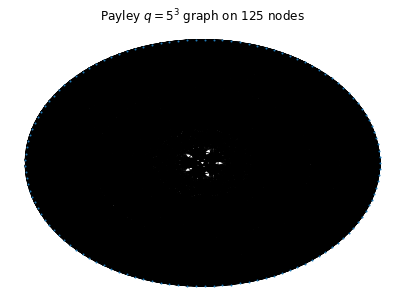

In [3]:
# save layout
pos = nx.shell_layout(G)

fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('Payley $q={}^{}$ graph on {} nodes'.format(p, exponent, G.number_of_nodes()))
ax.axis('off')

plt.show()

### Eigenvalues vs Alon-Boppana bound

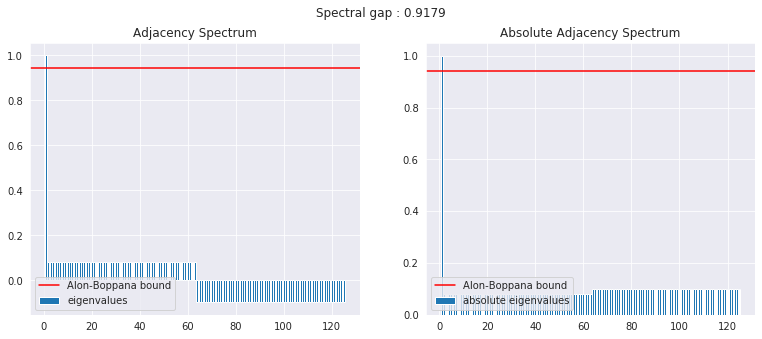

In [4]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(13, 5), nrows=1, ncols=2)

    fig.suptitle('Spectral gap : {:.4f}'.format(builder.normalized_spectral_gap))
    
    ax = axes[0]    
    ax.bar(range(1, n+1), builder.normalized_spectrum, label='eigenvalues')
    ax.axhline(y=alon_boppana(3, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Adjacency Spectrum')
    ax.legend(loc='lower left')

    ax = axes[1]
    ax.bar(range(1, n+1), np.abs(builder.normalized_spectrum), label='absolute eigenvalues')
    ax.axhline(y=alon_boppana(3, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Absolute Adjacency Spectrum')
    ax.legend(loc='lower left')

    plt.show()

In [5]:
builder.is_ramanujan

True

## Spectral and mixing properties : comparison with balanced trees.

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


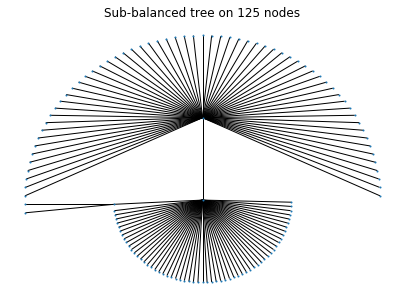

In [6]:
d = (q-1)//2
h = int(np.floor(np.log(n*(d-2) + 1)/np.log(d-1))) - 1
# Consider one extra height level in the tree...
G_tree = nx.balanced_tree(d-1, h+1)
# ... and remove the additional nodes to have the same number of nodes as G
G_tree = nx.MultiGraph(G_tree.subgraph(list(G_tree.nodes)[:n]))

# To make it more regular, add self-edges to the leaves.
leaves = [node for node in G_tree.nodes if G_tree.degree(node) == 1]
G_tree.add_edges_from([(leaf, leaf) for leaf in leaves for _ in range(d-1)])

# save layout
pos = nx.drawing.nx_agraph.graphviz_layout(G_tree, prog='twopi', args='')

fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

nx.draw_networkx(G_tree, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('Sub-balanced tree on {} nodes'.format(n))
ax.axis('off')

plt.show()

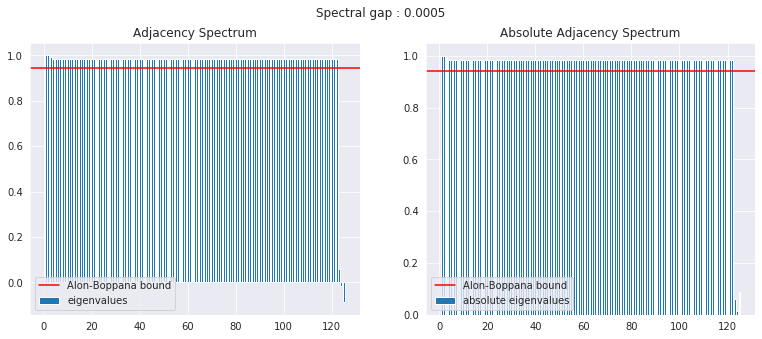

In [7]:
P_tree = transition_matrix(G_tree)

spectrum_tree = normalized_spectrum(P_tree)
spectral_gap_tree = spectral_gap(spectrum_tree)

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(13, 5), nrows=1, ncols=2)

    fig.suptitle('Spectral gap : {:.4f}'.format(spectral_gap_tree))
    
    ax = axes[0]    
    ax.bar(range(1, n+1), spectrum_tree, label='eigenvalues')
    ax.axhline(y=alon_boppana(3, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Adjacency Spectrum')
    ax.legend(loc='lower left')

    ax = axes[1]
    ax.bar(range(1, n+1), np.abs(spectrum_tree), label='absolute eigenvalues')
    ax.axhline(y=alon_boppana(3, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Absolute Adjacency Spectrum')
    ax.legend(loc='lower left')

    plt.show()

### Mixing times

Note that graphs extracted from balanced trees induce periodic Markov chain walks (of period 2 : every round trip from one node to itself takes an even number of steps because there is a single path connecting any two points in the tree, therefore the only way to make round trips is to go somewhere in the tree and trace the steps back). 

This would prevent the mixing, in the sense that $P^t$ would not converge to the stationary distribution when $t\rightarrow \infty$. That is why we have added an extra self-edge to the leaves, making the walks aperiodic.

100%|██████████| 10/10 [00:00<00:00, 25.94it/s]


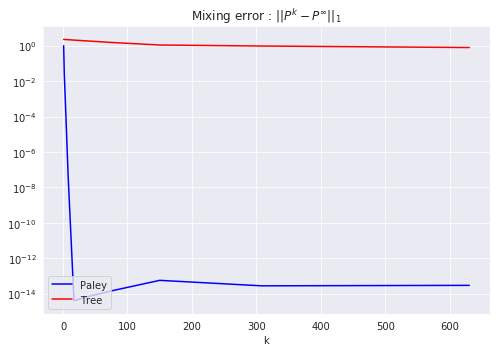

In [8]:
MIXING_METRIC = 1

P_inf = np.array([builder.invariant_distribution,]*n)

mu_tree = invariant_distribution(P_tree)
P_inf_tree = np.array([mu_tree,]*len(mu_tree))

# Log scale of exponents to test
exponents = np.unique(np.logspace(0, 2.8, 10, dtype=int))
n_iter = len(exponents)

mixing_err = np.zeros(n_iter)
mixing_err_tree = np.zeros(n_iter)

with tqdm(total=n_iter) as pbar:
    for k, exponent in enumerate(exponents):
        Pk = builder.transition_matrix ** exponent
        mixing_err[k] = np.linalg.norm(Pk-P_inf, MIXING_METRIC)

        Pk_tree = P_tree ** exponent
        mixing_err_tree[k] = np.linalg.norm(Pk_tree-P_inf_tree, MIXING_METRIC)
        pbar.update(1)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.semilogy(exponents, mixing_err, label='Paley', color='b')
    ax.semilogy(exponents, mixing_err_tree, label='Tree', color='r')
    ax.set_xlabel('k')
    ax.set_title('Mixing error : $||P^k - P^{\infty}||_{1}$')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Expected entropic evolution

Compute $t\mapsto \mathbb{E}\big[H(vP^t) - H(v)\big]$ i.e the increase in entropy after $t$ steps of mixing average across random initial distribution $v$ sampled uniformly.

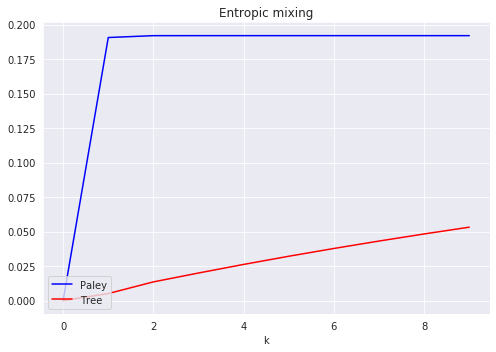

In [9]:
walk_length = 10
n_samples = int(1e3)
entropy_diff = builder.entropy_mixing(n_samples, walk_length)

entropy_diff_tree = entropy_mixing(P_tree, n_samples, walk_length)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(entropy_diff, label='Paley', color='b')
    ax.plot(entropy_diff_tree, label='Tree', color='r')
    ax.set_xlabel('k')
    ax.set_title('Entropic mixing')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Mutual Information Mixing

We define the Mutual Information Mixing on graph $\mathcal{G}$ as :
$$
mi_t = MI(X_0, X_t) = KL(p_{(X_0, X_t)} || p_{X_0} \otimes p_{X_t} )
$$
where $X_0 \sim \text{Uniform}(\mathcal{G})$ and $X_t = \text{random state of the walk on } \mathcal{G} \text{ after } t \text{ steps}$.

Intuitively, if a graph has good mixing properties, the distribution of $X_t$ shares very little information with the initial seeding $X_0$.

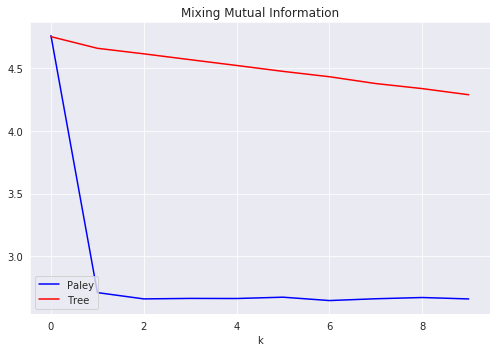

In [10]:
walk_length = 10
n_samples = int(1e3)
mixing_mi = builder.mi_mixing(n_samples, walk_length)

mixing_mi_tree = mi_mixing(P_tree, n_samples, walk_length)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(mixing_mi, label='Paley', color='b')
    ax.plot(mixing_mi_tree, label='Tree', color='r')
    ax.set_xlabel('k')
    ax.set_title('Mixing Mutual Information')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

## Spectral and mixing properties : comparison with random Erdös-Renyi graph of same expected degree.

An Erdös-Renyi graph $G(n,p)$ exhibits a connectivity transition phase with sharp threshold for $p$ equal to $\frac{\log n}{n}$, i.e if $p>\frac{(1+\varepsilon) \log n}{n}$ it will almost surely be connected, for $n$ large enough.

In [11]:
def generate_erdos_renyi(verbose=False):
    """Helper routine to generate Erdös-Renyi graphs on n vertices
    with average degree 3.
    """
    d = (q-1) // 2
    prob = d / (n-1)
    max_try = 100
    for k in range(max_try):
        G_Erdos_Renyi = nx.fast_gnp_random_graph(n, prob)
        if nx.is_connected(G_Erdos_Renyi):
            if verbose:
                print('G(n,p) is connected after {} trial(s)'.format(k+1))
            break
    else:
        if verbose:
            print('G(n,p) is not connected after {} trials'.format(max_try))
        return nx.Graph()
    
    return G_Erdos_Renyi

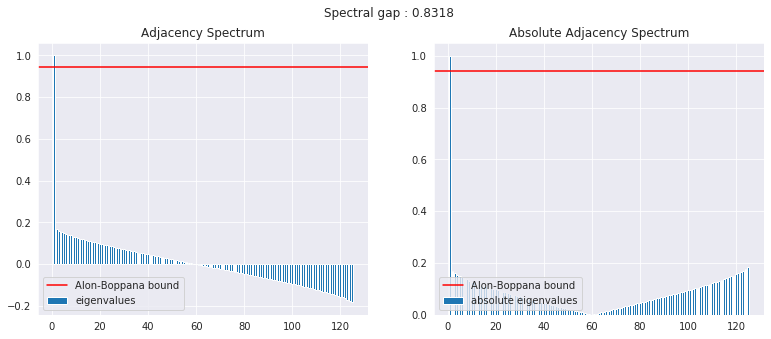

In [12]:
# Average mixing errors over a few Erdos-Renyi graphs
n_Erdos_Renyi = 20
Gs_Erdos_Renyi = [generate_erdos_renyi() for _ in range(n_Erdos_Renyi)]
Ps_Erdos_Renyi = [transition_matrix(G_ER) for G_ER in Gs_Erdos_Renyi]
spectrums_Erdos_Renyi = [normalized_spectrum(P_ER) for P_ER in Ps_Erdos_Renyi]
spectral_gaps_Erdos_Renyi = [spectral_gap(spectrum_ER) for spectrum_ER in spectrums_Erdos_Renyi]

spectrum_Erdos_Renyi = np.mean(np.array(spectrums_Erdos_Renyi), axis=0)
spectral_gap_Erdos_Renyi = np.mean(np.array(spectral_gaps_Erdos_Renyi), axis=0)

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(13, 5), nrows=1, ncols=2)

    fig.suptitle('Spectral gap : {:.4f}'.format(spectral_gap_Erdos_Renyi))
    
    ax = axes[0]    
    ax.bar(range(1, n+1), spectrum_Erdos_Renyi, label='eigenvalues')
    ax.axhline(y=alon_boppana(3, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Adjacency Spectrum')
    ax.legend(loc='lower left')

    ax = axes[1]
    ax.bar(range(1, n+1), np.abs(spectrum_Erdos_Renyi), label='absolute eigenvalues')
    ax.axhline(y=alon_boppana(3, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Absolute Adjacency Spectrum')
    ax.legend(loc='lower left')

    plt.show()

### Mixing times

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


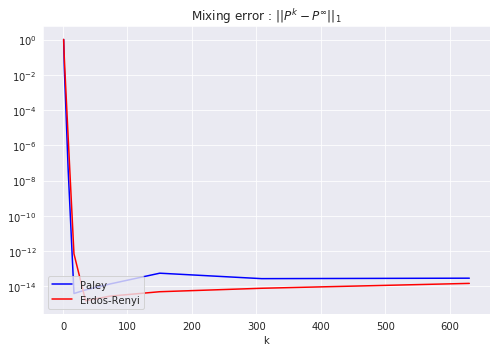

In [13]:
MIXING_METRIC = 1

P_inf = np.array([builder.invariant_distribution,]*n)
mus_Erdos_Renyi = [invariant_distribution(P_ER) for P_ER in Ps_Erdos_Renyi]
Ps_inf_Erdos_Renyi = [np.array([mu_ER,]*n) for mu_ER in mus_Erdos_Renyi]

# Log scale of exponents to test
exponents = np.unique(np.logspace(0, 2.8, 10, dtype=int))
n_iter = len(exponents)

mixing_err = np.zeros(n_iter)
mixing_err_Erdos_Renyi = np.zeros(n_iter)

with tqdm(total=n_iter) as pbar:
    for k, exponent in enumerate(exponents):
        Pk = builder.transition_matrix ** exponent
        mixing_err[k] = np.linalg.norm(Pk-P_inf, MIXING_METRIC)

        for i in range(n_Erdos_Renyi):
            Pk_Erdos_Renyi = Ps_Erdos_Renyi[i] ** exponent
            mixing_err_Erdos_Renyi[k] += np.linalg.norm(Pk_Erdos_Renyi-Ps_inf_Erdos_Renyi[i], MIXING_METRIC)/n_Erdos_Renyi
        pbar.update(1)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.semilogy(exponents, mixing_err, label='Paley', color='b')
    ax.semilogy(exponents, mixing_err_Erdos_Renyi, label='Erdos-Renyi', color='r')
    ax.set_xlabel('k')
    ax.set_title('Mixing error : $||P^k - P^{\infty}||_{1}$')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Expected entropic evolution

100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


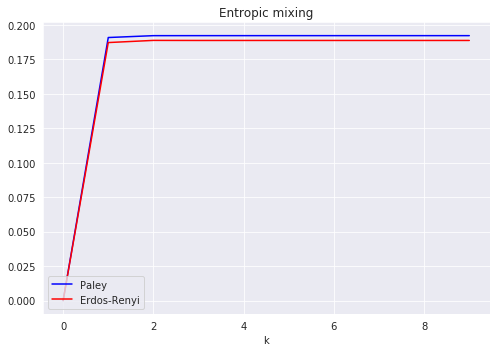

In [14]:
walk_length = 10
n_samples = int(1e3)
entropy_diff = builder.entropy_mixing(n_samples, walk_length)

entropy_diff_Erdos_Renyi = np.zeros(walk_length)
with tqdm(total=n_Erdos_Renyi) as pbar:
    for i, P_ER in enumerate(Ps_Erdos_Renyi):
        entropy_diff_Erdos_Renyi += entropy_mixing(P_ER, n_samples, walk_length) / n_Erdos_Renyi
        pbar.update(1)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(entropy_diff, label='Paley', color='b')
    ax.plot(entropy_diff_Erdos_Renyi, label='Erdos-Renyi', color='r')
    ax.set_xlabel('k')
    ax.set_title('Entropic mixing')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Mutual Information Mixing

100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


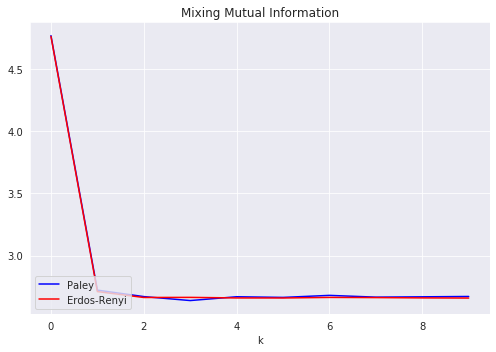

In [15]:
walk_length = 10
n_samples = int(1e3)
mixing_mi = builder.mi_mixing(n_samples, walk_length)

mixing_mi_Erdos_Renyi = np.zeros(walk_length)
with tqdm(total=n_Erdos_Renyi) as pbar:
    for i, P_ER in enumerate(Ps_Erdos_Renyi):
        mixing_mi_Erdos_Renyi += mi_mixing(P_ER, n_samples, walk_length) / n_Erdos_Renyi
        pbar.update(1)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(mixing_mi, label='Paley', color='b')
    ax.plot(mixing_mi_Erdos_Renyi, label='Erdos-Renyi', color='r')
    ax.set_xlabel('k')
    ax.set_title('Mixing Mutual Information')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Conclusion

Paley graphs are Ramanujan graphs, therefore they inherit good mixing properties.
However they are rather dense (each node is connected to half of the other nodes).